In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import ifft
from math import factorial
plt.rcParams.update({'font.size': 14})

## 2.1 e) Diagramme de bifurcation

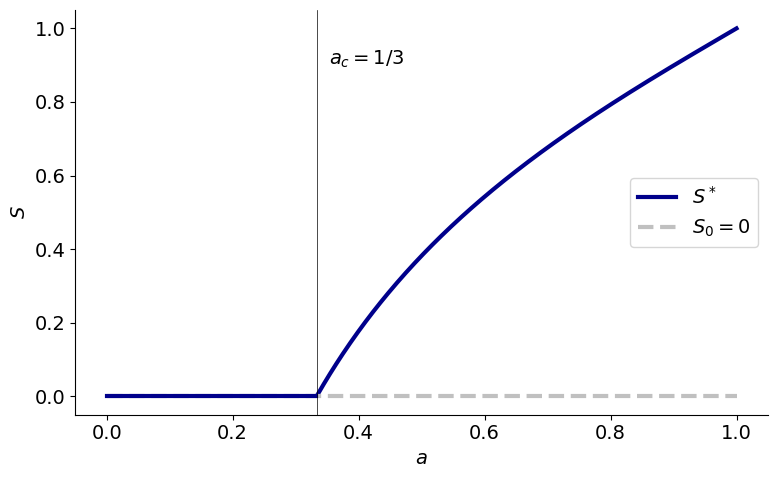

In [2]:
def S(a):
    # On force S = 0 (valeur plancher) en dessous de la valeur critique a_c = 1/3.
    S_vals = np.zeros_like(a)
    # Pour a > 1/3, S est donné par la forme fermée.
    mask = a > 1/3
    u = ((2 - a[mask]) - np.sqrt(a[mask] * (4 - 3 * a[mask]))) / (2 * a[mask])
    S_vals[mask] = 1 - (1 - a[mask]) / (1 - a[mask] * u)
    return S_vals

a = np.linspace(0, 1, 500)
S_vals = S(a)


plt.figure(figsize=(8,5))


# S^* (solution non triviale)
#plt.plot(a[a <= 1/3], S_vals[S_vals <= 1/3], '--', color='silver', label=r"$S^*$", linewidth=3)
plt.plot(a[a > 1/3], S_vals[a > 1/3], color='darkblue', linewidth=3, label=r"$S^*$")

# S_0 = 0 (solution triviale)
plt.plot(a, np.zeros_like(a), '--', color='silver', label=r"$S_0 = 0$", linewidth=3)
plt.plot(a[a <= 1/3], np.zeros_like(a[a <= 1/3]), color='darkblue', linewidth=3)

plt.axvline(1/3, color="black", linestyle="-", linewidth=0.5)
plt.text(1/3 + 0.02, 0.9, r"$a_c = 1/3$", fontsize=14, color="black")
plt.xlabel(r"$a$")
plt.ylabel(r"$S$")
plt.legend(loc="center right")
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.savefig("diagramme_bifurcation_S.png", dpi=200)
plt.show()


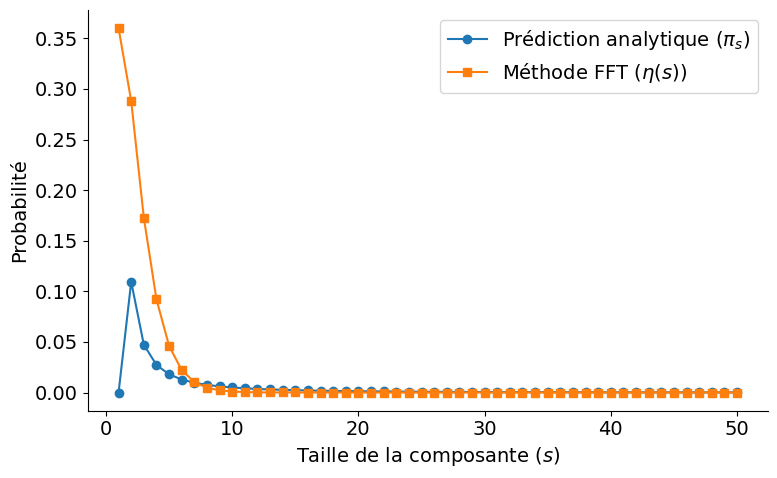

In [27]:
# def pi_s_fermee(a, s):
#     # Formule fermée pour pi_s (s >= 2)
#     return (1-a)**(2*s-1) * factorial(3*s-2) / (factorial(s-1) * factorial(2*s-1)) * a**s


def pi_s_fermee(a, s):
    if s == 1:
        return 1 - a
    return (1 - a)**(2*s - 1) * a**(s - 1) * factorial(3*s - 3) / (factorial(s - 1) * factorial(2*s - 1))

# def pi_1(a):
#     return 1 - a

# Paramètres
a = 0.4
s_max = 50
N = 512  # Nombre de points FFT (doit être > s_max)

# Distribution analytique
s_vals = np.arange(1, s_max+1)
pi_vals = np.zeros_like(s_vals, dtype=float)

for i, s in enumerate(s_vals[1:], start=1):
    pi_vals[i] = pi_s_fermee(a, s)

# Méthode FFT (Annexe D)
def G1(z):
    return ((1-a)**2) / (1 - a*z)**2

def K(z):
    return z * G1(z)  # ATTENTION: pour la méthode générale, K(z) = z * g(A(z)) avec A(z) solution de A = z f(A)

r = 1.0  # Rayon (si vous changez r, le facteur r**s ci-dessous est indispensable)
phi = np.linspace(0, 2*np.pi, N, endpoint=False)
z_points = r * np.exp(1j * phi)
K_points = K(z_points)

# FFT directe + extraction correcte des coefficients
eta_full = np.fft.fft(K_points) / N  # correspond à e^{-2π i n k/N}
s_idx = np.arange(1, s_max+1)
eta_fft = np.real(eta_full[s_idx]) / (r**s_idx)  # applique 1/r^s

# # Normalisation pour que la somme des probabilités soit de 1. [IMPORTANT POUR LA COMPARAISON]
eta_fft = eta_fft / np.sum(eta_fft)
S = 1 - (1-a)/(1-a*(1 - a))  # On utilise la formule exacte pour S
pi_vals = pi_vals / (1-S) # np.sum(pi_vals)  # ou pi_vals / (1-S) pour la vraie normalisation

# π_s = (1−a)^{2s−1} a^{s−1} (3s−3)! / [(s−1)! (2s−1)!], avec π_1 = 1−a.

plt.figure(figsize=(8,5))
plt.plot(s_vals, pi_vals, 'o-', label=r"Prédiction analytique ($\pi_s$)")
plt.plot(s_vals, eta_fft, 's-', label=r"Méthode FFT ($\eta(s)$)")
plt.xlabel("Taille de la composante ($s$)")
plt.ylabel("Probabilité")
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("comparaison_distributions_petites_composantes.png", dpi=200)
plt.show()

In [103]:
# Quantification de l'écart MES (erreur quadratique moyenne) entre deux distributions
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mes = mean_squared_error(pi_vals, eta_fft)
print(f"Erreur quadratique moyenne (MES) entre les deux distributions : {mes:.3e}")

Erreur quadratique moyenne (MES) entre les deux distributions : 4.877e-04


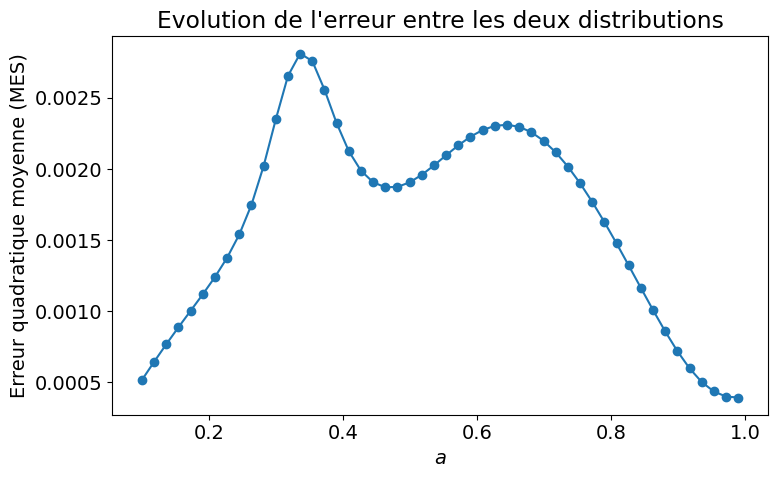

In [5]:

a_values = np.linspace(0.1, 0.99, 50)#0.333, 50)
mes_values = []

# Méthode FFT
def G1(z,a):
    return ((1-a)**2) / (1 - a*z)**2
def K(z,a):
    return z * G1(z,a)

for a_test in a_values:
    # Distribution analytique
    s_vals = np.arange(1, s_max+1)
    pi_vals = np.zeros_like(s_vals, dtype=float)
    pi_vals[0] = 1 - a_test
    for i, s in enumerate(s_vals[1:], start=1):
        pi_vals[i] = (1-a_test)**(2*s-1) * factorial(3*s-2) / (factorial(s-1) * factorial(2*s-1)) * a_test**s

    # phi = np.linspace(0, 2*np.pi, N, endpoint=False)
    # z_points = np.exp(1j * phi)
    # K_points = K(z_points,a_test)
    # eta_fft = np.real(ifft(K_points)) / r
    # eta_fft = eta_fft[1:s_max+1][::-1]
    # eta_fft = eta_fft / np.sum(eta_fft)


    r = 1.0  # Rayon (si vous changez r, le facteur r**s ci-dessous est indispensable)
    phi = np.linspace(0, 2*np.pi, N, endpoint=False)
    z_points = r * np.exp(1j * phi)
    K_points = K(z_points, a_test)

    # FFT directe + extraction correcte des coefficients
    eta_full = np.fft.fft(K_points) / N  # correspond à e^{-2π i n k/N}
    s_idx = np.arange(1, s_max+1)
    eta_fft = np.real(eta_full[s_idx]) / (r**s_idx)  # applique 1/r^s

    # Facultatif: normalisation pour comparaison de forme
    eta_fft = eta_fft / np.sum(eta_fft)

    # MES
    mes = np.mean((pi_vals - eta_fft) ** 2)
    mes_values.append(mes)

plt.figure(figsize=(8,5))
plt.plot(a_values, mes_values, marker='o')
plt.xlabel(r"$a$")
plt.ylabel("Erreur quadratique moyenne (MES)")
plt.title("Evolution de l'erreur entre les deux distributions")
plt.tight_layout()
plt.show()
